In [1]:
import numpy as np
import camb
from camb import model
import matplotlib.pyplot as plt
import healpy as hp
from tqdm import tqdm

In [13]:
params = camb.CAMBparams()
params.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.12, mnu=0.06, omk=0)
params.InitPower.set_params(ns=0.965)
results = camb.get_results(params)
powers = results.get_cmb_power_spectra(params, CMB_unit="K")


tt_spectrum = powers['total'].T[0]
ell_values = np.arange(len(tt_spectrum))

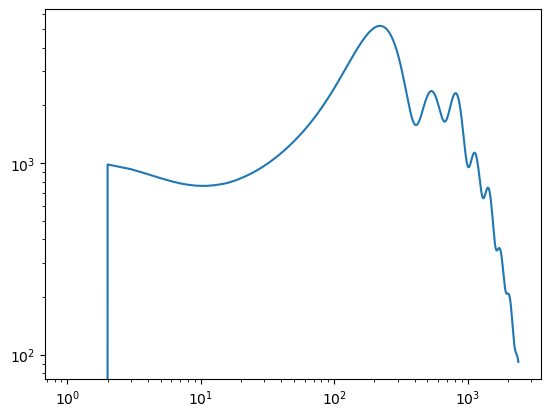

In [3]:
plt.loglog(ell_values,tt_spectrum)

In [4]:
nside = 16
#temperature_map = hp.synfast(tt_spectrum, nside, new=True)
temperature_map = hp.read_map('./DATA/SMICA_16.fits')

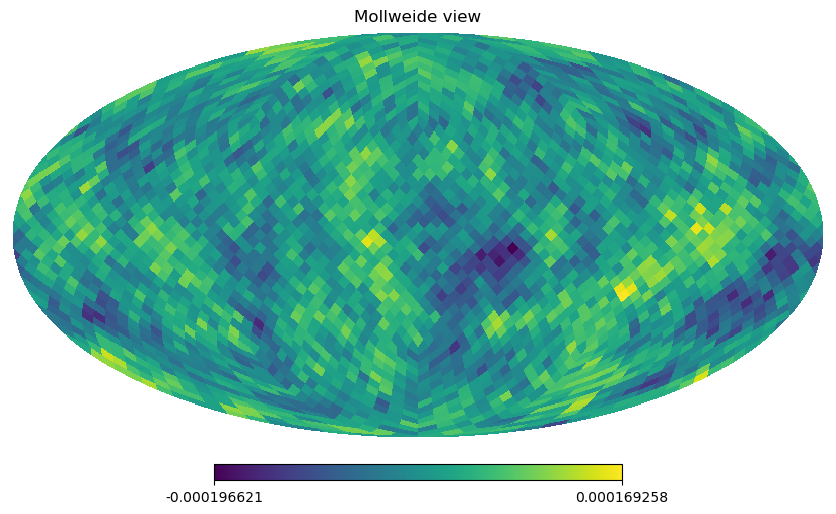

In [5]:
hp.mollview(temperature_map)

In [6]:
npix = hp.nside2npix(nside)
patch_radius_deg = 40.0

In [7]:

def get_random_patch_indices(nside,npix,patch_radius_deg):
    random_pixel_index = np.random.randint(0, npix)
    theta, phi = hp.pix2ang(nside, random_pixel_index)
    patch_pixel_indices = hp.query_disc(nside, hp.ang2vec(theta, phi), np.radians(patch_radius_deg))
    return patch_pixel_indices

def two_patches(p1,p2):
    if len(p1) != len(p2):
        #print("Patches dont have the same size")
        m = min(len(p1),len(p2))
        return p1[:m], p2[:m]
    else:
        return p1, p2

def show_patches(npix,p1,p2):
    p1, p2 = two_patches(p1,p2)
    m = np.zeros(npix)
    m[p1] = 1
    m[p2] = 2
    hp.mollview(m, title="Patch 1 and 2",cmap='jet')
    plt.show()


In [8]:
p1 = get_random_patch_indices(nside,npix,patch_radius_deg)
p2 = get_random_patch_indices(nside,npix,patch_radius_deg)

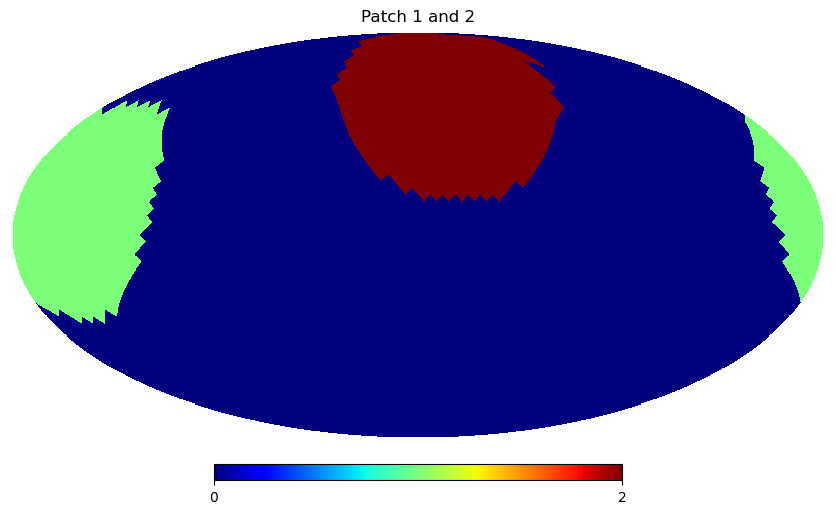

In [9]:
show_patches(npix,p1,p2)

In [10]:
def patch_swap(map_to_swap,p1,p2):
    p1,p2 = two_patches(p1,p2)
    if len(p1) != len(p2):
        raise ValueError("Patches must be of the same size")
    map_ = map_to_swap.copy()
    patch1 = map_[p1]
    patch2 = map_[p2]
    map_[p1] = patch2
    map_[p2] = patch1
    return map_

In [11]:
num_shuffles = 1000
power_spectra_array = []
for _ in tqdm(range(num_shuffles), desc="Shuffling the patches", unit="iteration"):
    p1 = get_random_patch_indices(nside,npix,patch_radius_deg)
    p2 = get_random_patch_indices(nside,npix,patch_radius_deg)
    temp_map = temperature_map.copy()
    temp_map_swap = patch_swap(temp_map,p1,p2)
    power_spectrum = hp.anafast(temp_map_swap)
    power_spectra_array.append(power_spectrum)
mean_power_spectrum = np.mean(power_spectra_array, axis=0)


Shuffling the patches: 100%|██████████| 1000/1000 [00:01<00:00, 556.52iteration/s]


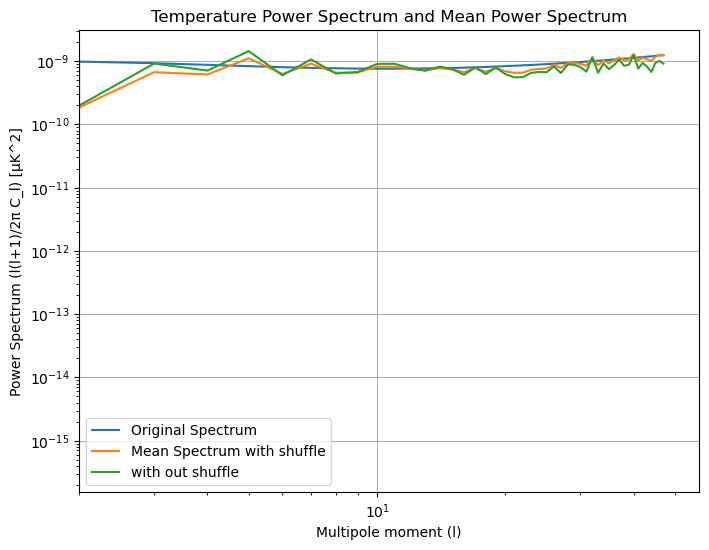

In [14]:
ltt = len(mean_power_spectrum)
dl = ell_values[:ltt]*(ell_values[:ltt]+1)/(2*np.pi)
plt.figure(figsize=(8, 6))
plt.plot(ell_values[:ltt], tt_spectrum[:ltt], label="Original Spectrum")
plt.plot(ell_values[:ltt], mean_power_spectrum*dl, label="Mean Spectrum with shuffle")
plt.loglog(ell_values[:ltt], hp.anafast(temperature_map)*dl,label='with out shuffle')
plt.xlabel('Multipole moment (l)')
plt.ylabel('Power Spectrum (l(l+1)/2π C_l) [μK^2]')
plt.title('Temperature Power Spectrum and Mean Power Spectrum')
plt.legend()
plt.xlim(2,None)
#plt.ylim(1e2,1e4)
plt.grid()
plt.show()